(quick_echopype_exercise)=
# Echopype: A quick exercise

In this exercise we will do 4 things:
- convert a `.raw` file collected by an EK80 echosounder
- compute volume backscattering strength (Sv) from the parsed raw data
- regrid the Sv data to mean volume backscattering strength (MVBS)
- visualize using interactive plot

The details verbally discussed during the workshop can be found in the [Getting started with Echopype notebook](https://echopype-examples.readthedocs.io/en/latest/getting_started.html) with some additional information, in the ["echopype-examples" repository](https://github.com/OSOceanAcoustics/echopype-examples).

In [1]:
import echopype as ep  # we recommend using "ep"
import xarray as xr
import hvplot.xarray  # for interactive plots

import matplotlib.pyplot as plt

### Convert a `.raw` file

Echopype supports accessing data directly from multiple sources, such as a local filesystem (e.g., hard disk), a cloud object store (e.g., AWS S3), an http server, etc.

In [16]:
# Convert from an S3 bucket
#raw_path = "s3://noaa-wcsd-pds/data/raw/Bell_M._Shimada/SH2306/EK80/Hake-D20230811-T165727.raw"
raw_path = "s3://noaa-wcsd-pds/data/raw/Bell_M._Shimada/SH2306/EK80/Hake-D20230810-T213028.raw"

ed = ep.open_raw(
    raw_path,
    sonar_model="EK80",
    storage_options={"anon": True},  # open bucket, otherwise need credential
)

### Check what's in the raw file

In [17]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

### Save the `EchoData` object

In [18]:
# Save to zarr
ed.to_zarr("./resources", overwrite="w")  # save with the same filename, different extension

In [19]:
# Save to netCDF
ed.to_netcdf("./resources/Hake-D20230810-T213028.nc", overwrite="w")  # fully specify the filename also works

### Im-memory vs lazy-loaded data

In [20]:
# Lazy-load EchoData using xarray kwargs (keyword arguments)
ed_lazy = ep.open_converted("./resources/Hake-D20230810-T213028.zarr", chunks={})

In [21]:
# In-memory
ed["Sonar/Beam_group1"]["backscatter_r"]

<xarray.DataArray 'backscatter_r' (channel: 5, ping_time: 214,
                                   range_sample: 36198)> Size: 155MB
array([[[  10.30087   ,   13.781529  ,   15.945183  , ...,
                   nan,           nan,           nan],
        [  10.289111  ,   13.781529  ,   15.933423  , ...,
                   nan,           nan,           nan],
        [  10.289111  ,   13.758012  ,   15.898147  , ...,
                   nan,           nan,           nan],
        ...,
        [  10.242075  ,   13.746252  ,   15.933423  , ...,
                   nan,           nan,           nan],
        [  10.265594  ,   13.781529  ,   15.933423  , ...,
                   nan,           nan,           nan],
        [  10.277352  ,   13.758012  ,   15.898147  , ...,
                   nan,           nan,           nan]],

       [[ -11.770743  ,   -5.6678305 ,   -0.48211834, ...,
         -148.17496   , -135.18127   , -130.1602    ],
        [ -11.5826    ,   -5.5619993 ,   -0.41156444, ...,
         -131.39488   , -130.32481   , -131.23026   ],
        [ -11.817779  ,   -5.7031074 ,   -0.50563633, ...,
         -123.09305   , -122.68148   , -122.5051    ],
...
        [   3.4806592 ,   10.371424  ,   15.7335205 , ...,
                   nan,           nan,           nan],
        [   3.621767  ,   10.477255  ,   15.815834  , ...,
                   nan,           nan,           nan],
        [   3.5864902 ,   10.453737  ,   15.815834  , ...,
                   nan,           nan,           nan]],

       [[   6.196985  ,    9.019141  ,   10.924096  , ...,
                   nan,           nan,           nan],
        [   6.2087436 ,    9.019141  ,   10.924096  , ...,
                   nan,           nan,           nan],
        [   5.9735637 ,    8.819238  ,   10.724194  , ...,
                   nan,           nan,           nan],
        ...,
        [   6.196985  ,    9.019141  ,   10.924096  , ...,
                   nan,           nan,           nan],
        [   6.196985  ,    9.019141  ,   10.924096  , ...,
                   nan,           nan,           nan],
        [   6.2087436 ,    9.019141  ,   10.924096  , ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * channel       (channel) <U25 500B 'WBT 400140-15 ES120-7C_ES' ... 'WBT 40...
  * ping_time     (ping_time) datetime64[ns] 2kB 2023-08-10T21:30:28.548555 ....
  * range_sample  (range_sample) int32 145kB 0 1 2 3 ... 36194 36195 36196 36197
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

In [8]:
# Lazy-loaded
ed_lazy["Sonar/Beam_group1"]["backscatter_r"]

<xarray.DataArray 'backscatter_r' (channel: 5, ping_time: 213,
                                   range_sample: 36198)> Size: 154MB
dask.array<open_dataset-backscatter_r, shape=(5, 213, 36198), dtype=float32, chunksize=(5, 213, 23474), chunktype=numpy.ndarray>
Coordinates:
  * channel       (channel) <U25 500B 'WBT 400140-15 ES120-7C_ES' ... 'WBT 40...
  * ping_time     (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ....
  * range_sample  (range_sample) int32 145kB 0 1 2 3 ... 36194 36195 36196 36197
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

### Compute Sv

In [22]:
# Use the correct waveform_mode and encode_mode combination
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")
ds_Sv = ep.consolidate.add_depth(ds_Sv, ed)

Check how the Sv data look like:

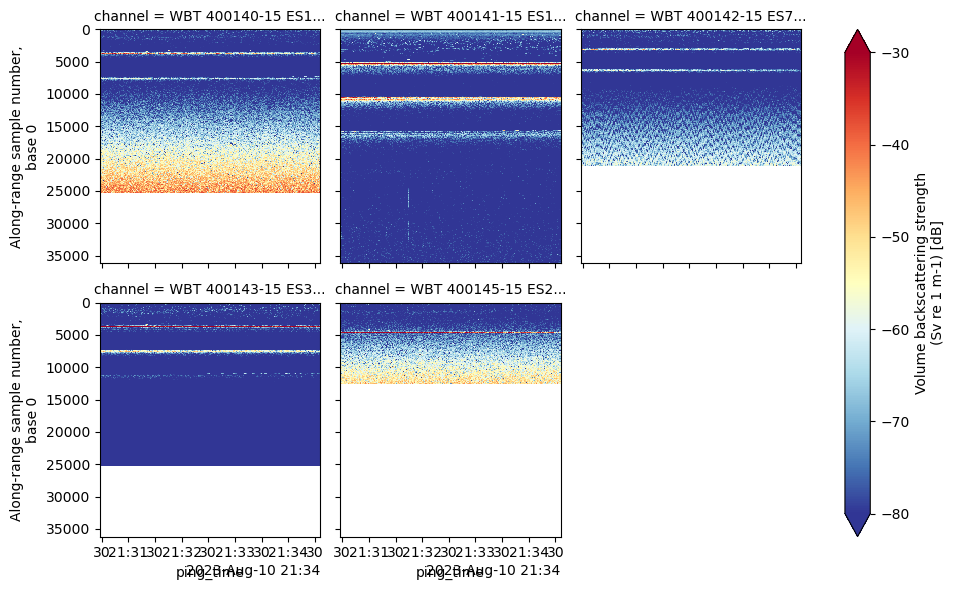

In [23]:
ds_Sv["Sv"].plot(
    x="ping_time", 
    row="channel", col_wrap=3,
    vmin=-80, vmax=-30,
    cmap="RdYlBu_r", yincrease=False
)

### Regrid to MVBS

In [24]:
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin="1m",
    ping_time_bin="5s",
    range_var_max="500m",  # max range to bin
)

In [14]:
ds_MVBS

<xarray.Dataset> Size: 2MB
Dimensions:            (frequency_nominal: 5, ping_time: 97, depth: 501)
Coordinates:
  * ping_time          (ping_time) datetime64[ns] 776B 2023-08-11T16:57:25 .....
    channel            (frequency_nominal) <U25 500B 'WBT 400140-15 ES120-7C_...
  * depth              (depth) float64 4kB 0.0 1.0 2.0 3.0 ... 498.0 499.0 500.0
  * frequency_nominal  (frequency_nominal) float64 40B 1.2e+05 1.8e+04 ... 2e+05
Data variables:
    Sv                 (frequency_nominal, ping_time, depth) float64 2MB 5.56...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.10.1
    processing_time:              2025-04-07T16:05:36Z
    processing_function:          commongrid.compute_MVBS

See how MVBS data are now all aligned with one another (hence the name `commingrid`):

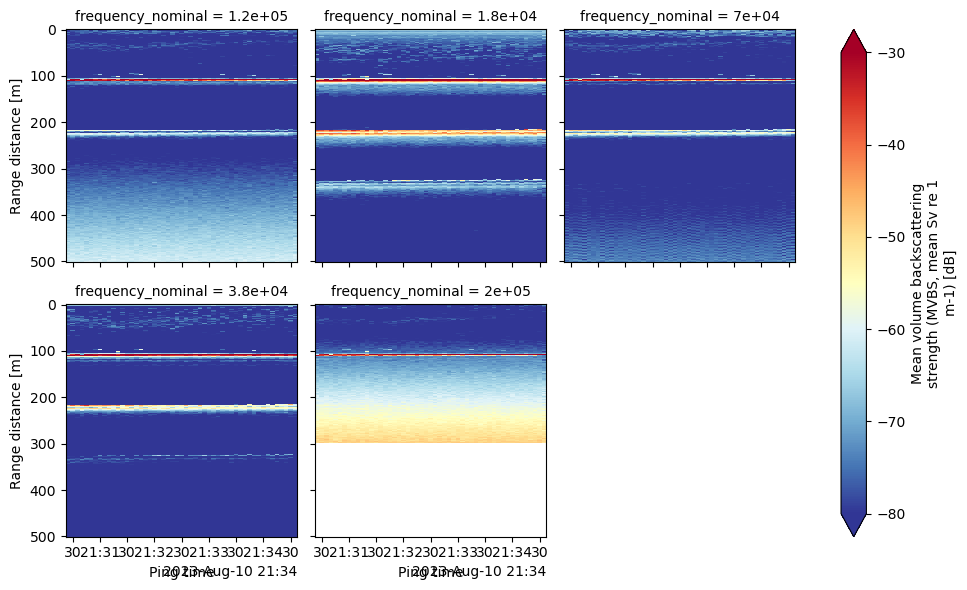

In [25]:
ds_MVBS = ds_MVBS.swap_dims({"channel": "frequency_nominal"})
ds_MVBS["Sv"].plot(
    x="ping_time",
    row="frequency_nominal", col_wrap=3,
    cmap='RdYlBu_r', yincrease=False,
    vmin=-80, vmax=-30
)

### Try interactive plotting

In [15]:
ds_MVBS["Sv"].hvplot.quadmesh(
    x="ping_time", clim=(-80, -30), figsize=(6, 6), cmap="RdYlBu_r", rasterize=True,
    groupby="frequency_nominal"
).opts(invert_yaxis=True, height=400)

:DynamicMap   [frequency_nominal]
   :Image   [ping_time,depth]   (Mean volume backscattering strength (MVBS, mean Sv re 1 m-1))

### Save the MVBS dataset for future use

In [14]:
ds_MVBS.to_zarr("./resources/Hake-D20230811-T165727_MVBS.zarr", mode="w")